# Searchlight

# Create simulated dataset

In [260]:
## Code for simulating the data: ##
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pymc3 as pm
np.random.seed(1)
num_conditions = 2
num_voxels = 8000

activations1=np.full(num_voxels,np.nan)
activations2=np.full(num_voxels,np.nan)

from scipy import signal
def make_noncirc_gaussian_iter(mu,sd,stim_max=360):
    if np.isscalar(mu):
        mu=[mu]
    if np.isscalar(sd):
        sd=[sd]
    return np.array([sp.stats.norm.pdf(np.arange(stim_max), m, s)
                         for m,s in zip(mu,sd)]).T
# create voxel tuning functions per condition
vox_tuning = np.full((num_voxels*num_conditions,5),np.nan)
for v in range(num_voxels):
    if np.random.randint(2)==0:
        vox_tuning[v,:] = make_noncirc_gaussian_iter([.5+np.random.rand()/2],[np.random.rand()+1],5).flatten()
        vox_tuning[v+num_voxels,:]=vox_tuning[v,:]
    else:
        vox_tuning[v,:] = make_noncirc_gaussian_iter([2.5+np.random.rand()/2],[np.random.rand()+1],5).flatten()
        vox_tuning[v+num_voxels,:]=vox_tuning[v,:]
        
for c in range(num_conditions):
    for v in range(num_voxels):
        if c==0:
            activations1[v]=vox_tuning[v,1]+np.random.rand()/2
        else:
            activations2[v]=vox_tuning[v,3]+np.random.rand()/2

x = y = z = np.linspace(0, 19, 20)
X,Y,Z=np.meshgrid(x,y,z)
coord=np.vstack((X.ravel(),Y.ravel(),Z.ravel())).T

x0 = 6
y0 = 6
z0 = 6
center=np.array([x0,y0,z0])
cutoff=5
data=np.vstack((X.ravel(),Y.ravel(),Z.ravel())).T
distance=sp.spatial.distance.cdist(data,center.reshape(1,-1)).ravel()
points_in_sphere=data[distance<cutoff]

activations1[distance<cutoff]+=1
    
np.save('activations1.npy',activations1)
np.save('activations2.npy',activations2)
np.save('coord.npy',coord)

# Load post-processed simulated data
Import our data. Look at how many subjects, trial conditions, and voxels we have to work with. 

Note that we follow Python conventions by numbering variables starting at 0 and not 1.

In [18]:
# general packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# pull data from GitHub
import requests, io
for array in ['activations1','activations2','coord']:
    globals()['{}'.format(array)] = np.load(io.BytesIO(requests.get(
        'http://paulscotti.github.io/navigateFMRI/methods/searchlight/{}.npy'.format(array)).content))
#activations1 = watching comedy
#activations2 = watching horror

In [15]:
# change default plotting
plt.rcParams.update({'font.size': 20, 'figure.figsize': (7,2)})

# Visualize our data

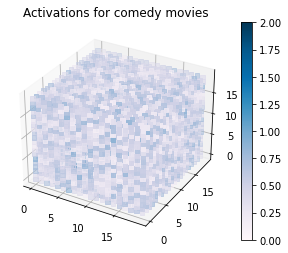

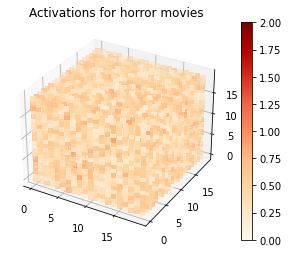

In [298]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
p = ax.scatter(coord[:,0],
           coord[:,1],
           coord[:,2],
           c=activations1,
           marker='s',vmin=0,vmax=2,
           cmap='PuBu')
fig.colorbar(p)
plt.title("Activations for comedy movies")
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
p = ax.scatter(coord[:,0],
           coord[:,1],
           coord[:,2],
           c=activations1,
           marker='s',vmin=0,vmax=2,
           cmap='OrRd')
fig.colorbar(p)
plt.title("Activations for horror movies")
plt.show()

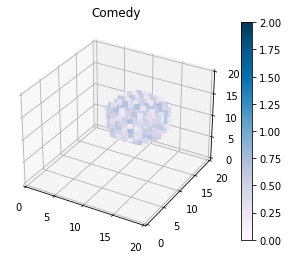

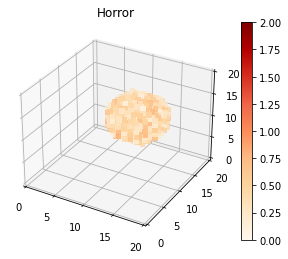

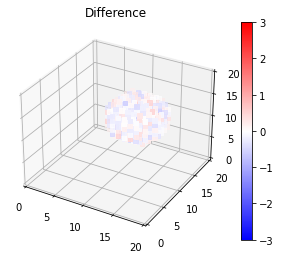

In [294]:
x0 = 12
y0 = 12
z0 = 12
center=np.array([x0,y0,z0])
cutoff=5

distance=sp.spatial.distance.cdist(coord,center.reshape(1,-1)).ravel()
points_in_sphere=coord[distance<cutoff]

fig = plt.figure()
ax = fig.gca(projection='3d')
p = ax.scatter(points_in_sphere[:,0],
           points_in_sphere[:,1],
           points_in_sphere[:,2],
           c=activations1[distance<cutoff],
           marker='s',cmap='PuBu',vmin=0,vmax=2)
fig.colorbar(p)
ax.set_xlim3d(0,20)
ax.set_ylim3d(0,20)
ax.set_zlim3d(0,20)
plt.title("Comedy")
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
p = ax.scatter(points_in_sphere[:,0],
           points_in_sphere[:,1],
           points_in_sphere[:,2],
           c=activations2[distance<cutoff],
           marker='s',cmap='OrRd',vmin=0,vmax=2)
fig.colorbar(p)
ax.set_xlim3d(0,20)
ax.set_ylim3d(0,20)
ax.set_zlim3d(0,20)
plt.title("Horror")
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
p = ax.scatter(points_in_sphere[:,0],
           points_in_sphere[:,1],
           points_in_sphere[:,2],
           c=activations2[distance<cutoff]-activations1[distance<cutoff],
           marker='s',cmap='bwr',vmin=-3,vmax=3)
fig.colorbar(p)
ax.set_xlim3d(0,20)
ax.set_ylim3d(0,20)
ax.set_zlim3d(0,20)
plt.title("Difference")
plt.show()

In [289]:
diffs=np.full(num_voxels,np.nan)
coord_tracker=np.full((num_voxels,3),np.nan)
cnt=0
for x0 in range(20):
    for y0 in range(20):
        for z0 in range(20):
            center=np.array([x0,y0,z0])
            distance=sp.spatial.distance.cdist(coord,center.reshape(1,-1)).ravel()
            points_in_sphere=coord[distance<cutoff]
            diffs[cnt] = np.abs(np.mean(activations2[distance<cutoff]-activations1[distance<cutoff]))
            coord_tracker[cnt,:]=[x0,y0,z0]
            cnt+=1

print("Largest absolute difference found at x={} y={} z={}".format(coord_tracker[np.argmax(diffs),0],
                                                             coord_tracker[np.argmax(diffs),1],
                                                             coord_tracker[np.argmax(diffs),2]))

Largest absolute difference found at x=6.0 y=6.0 z=6.0


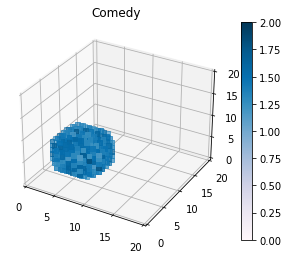

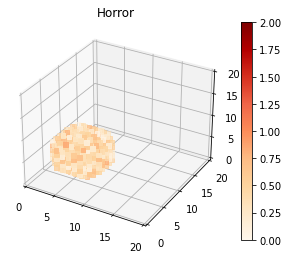

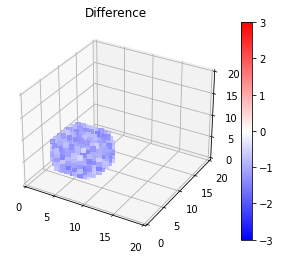

In [295]:
x0 = 6
y0 = 6
z0 = 6
center=np.array([x0,y0,z0])

distance=sp.spatial.distance.cdist(coord,center.reshape(1,-1)).ravel()
points_in_sphere=coord[distance<cutoff]

fig = plt.figure()
ax = fig.gca(projection='3d')
p = ax.scatter(points_in_sphere[:,0],
           points_in_sphere[:,1],
           points_in_sphere[:,2],
           c=activations1[distance<cutoff],
           marker='s',cmap='PuBu',vmin=0,vmax=2)
fig.colorbar(p)
ax.set_xlim3d(0,20)
ax.set_ylim3d(0,20)
ax.set_zlim3d(0,20)
plt.title("Comedy")
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
p = ax.scatter(points_in_sphere[:,0],
           points_in_sphere[:,1],
           points_in_sphere[:,2],
           c=activations2[distance<cutoff],
           marker='s',cmap='OrRd',vmin=0,vmax=2)
fig.colorbar(p)
ax.set_xlim3d(0,20)
ax.set_ylim3d(0,20)
ax.set_zlim3d(0,20)
plt.title("Horror")
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
p = ax.scatter(points_in_sphere[:,0],
           points_in_sphere[:,1],
           points_in_sphere[:,2],
           c=activations2[distance<cutoff]-activations1[distance<cutoff],
           marker='s',cmap='bwr',vmin=-3,vmax=3)
fig.colorbar(p)
ax.set_xlim3d(0,20)
ax.set_ylim3d(0,20)
ax.set_zlim3d(0,20)
plt.title("Difference")
plt.show()